In [1]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np


## Create a pipeline for data engineering

In [2]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
"dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
"logged_in","num_compromised","root_shell","su_attempted","num_root",
"num_file_creations","num_shells","num_access_files","num_outbound_cmds",
"is_host_login","is_guest_login","count","srv_count","serror_rate",
"srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
"diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
"dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","class","difficulty"]

nominal_cols = ['protocol_type','service','flag']
binary_cols = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login',
'is_guest_login']
continuous_cols = ['duration' ,'src_bytes', 'dst_bytes', 'wrong_fragment' ,'urgent', 'hot',
'num_failed_logins', 'num_compromised', 'num_root' ,'num_file_creations',
'num_shells', 'num_access_files', 'num_outbound_cmds', 'count' ,'srv_count',
'serror_rate', 'srv_serror_rate' ,'rerror_rate' ,'srv_rerror_rate',
'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate' ,'dst_host_count',
'dst_host_srv_count' ,'dst_host_same_srv_rate' ,'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate' ,'dst_host_srv_diff_host_rate',
'dst_host_serror_rate' ,'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']

dos = [
    "apache2", "back", "land", "neptune", "mailbomb", "pod",
    "processtable", "smurf", "teardrop", "udpstorm", "worm"
]
probe = [
    "ipsweep", "mscan", "nmap", "portsweep", "saint", "satan"
]
u2r = [
    "buffer_overflow", "loadmodule", "perl", "ps",
    "rootkit", "sqlattack", "xterm"
]
r2l = [
    "ftp_write", "guess_passwd", "httptunnel", "imap", "multihop",
    "named", "phf", "sendmail", "Snmpgetattack", "spy",
    "snmpguess", "warezclient", "warezmaster", "xlock", "xsnoop"
]


class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        label_to_class = udf(
            lambda name: 'dos' if name in dos else 
                         'probe' if name in probe else 
                         'u2r' if name in u2r else 
                         'r2l' if name in r2l else 
                         'normal', 
            StringType()
        )        
        output_df = dataset.withColumn('outcome', label_to_class(col('class'))).drop("class")  

        indexer = StringIndexer(inputCol= 'outcome', outputCol= 'outcome_index')
        output_df = indexer.fit(output_df).transform(output_df)

        encoder = OneHotEncoder(inputCol= 'outcome_index', outputCol= 'outcome_encoded', dropLast=False)
        output_df = encoder.fit(output_df).transform(output_df)
        
        output_df = output_df.drop('difficulty')

        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+binary_cols+nominal_onehot_cols
    corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
                     "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    

    # Stage for creating the outcome column representing whether there is attack 
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'])
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    return pipeline 

## Read data and split into 3 datasets

In [3]:
import os
import sys
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# os.environ['PYSPARK_PYTHON'] = sys.executable
# os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("SystemsToolChains") \
    .getOrCreate()

nslkdd_raw = spark.read.csv('KDDTrain+.txt',header=False).toDF(*col_names)
nslkdd_test_entire_raw = spark.read.csv('KDDTest+.txt',header=False).toDF(*col_names)

nslkdd_test_raw, nslkdd_validation_raw = nslkdd_test_entire_raw.randomSplit([0.5, 0.5])

preprocess_pipeline = get_preprocess_pipeline()

preprocess_pipeline_model = preprocess_pipeline.fit(nslkdd_raw)
nslkdd_df = preprocess_pipeline_model.transform(nslkdd_raw)

nslkdd_df_test = preprocess_pipeline_model.transform(nslkdd_test_raw)

nslkdd_df_validation = preprocess_pipeline_model.transform(nslkdd_validation_raw)



24/04/14 22:12:23 WARN Utils: Your hostname, Jacks-MacBook-Pro-3.local resolves to a loopback address: 127.0.0.1; using 172.16.0.4 instead (on interface en0)
24/04/14 22:12:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/14 22:12:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/14 22:12:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/04/14 22:12:35 ERROR Executor: Exception in task 1.0 in stage 8.0 (TID 15) 5]
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1100, in main
    raise PyS

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1100, in main
    raise PySparkRuntimeError(
pyspark.errors.exceptions.base.PySparkRuntimeError: [PYTHON_VERSION_MISMATCH] Python in worker has different version (3, 12) than that in driver 3.11, PySpark cannot run with different minor versions.
Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.


24/04/14 22:12:39 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [4]:
nslkdd_df_train_pandas = nslkdd_df.toPandas()
nslkdd_df_test_pandas = nslkdd_df_test.toPandas()
nslkdd_df_validate_pandas = nslkdd_df_validation.toPandas()


In [5]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader

class MyDataset(Dataset): 
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return (self.x[idx],self.y[idx])

In [6]:
x_train = torch.from_numpy(np.array(nslkdd_df_train_pandas['features'].values.tolist(), np.float32))
y_train = torch.from_numpy(np.array(nslkdd_df_train_pandas['outcome_encoded'].values.tolist()))

x_validate = torch.from_numpy(np.array(nslkdd_df_validate_pandas['features'].values.tolist(), np.float32))
y_validate = torch.from_numpy(np.array(nslkdd_df_validate_pandas['outcome_encoded'].values.tolist(), np.float32))

x_test = torch.from_numpy(np.array(nslkdd_df_test_pandas['features'].values.tolist(), np.float32))
y_test = torch.from_numpy(np.array(nslkdd_df_test_pandas['outcome_encoded'].values.tolist(), np.float32))



In [7]:
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)

torch.Size([125973, 5])
torch.Size([11206, 5])
torch.Size([11338, 5])


In [8]:
print(x_train.shape)
print(x_validate.shape)
print(x_test.shape)

torch.Size([125973, 113])
torch.Size([11206, 113])
torch.Size([11338, 113])


In [9]:
train_set = MyDataset(x_train,y_train)
validate_set = MyDataset(x_validate,y_validate)
test_set = MyDataset(x_test,y_test)

## Neural Network definition

In [10]:
# Example: using Sequential in Pytorch

class myMultiLayerPerceptron(nn.Module):
    def __init__(self,input_dim,output_dim):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(input_dim,50),
            nn.Tanh(),
            nn.Linear(50,20),
            nn.Tanh(),
            nn.Linear(20,output_dim)
        )
    def forward(self,x):
        y = self.sequential(x)
        return y
    
model1 = myMultiLayerPerceptron(113,5)
print(model1)
    


myMultiLayerPerceptron(
  (sequential): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=113, out_features=50, bias=True)
    (2): Tanh()
    (3): Linear(in_features=50, out_features=20, bias=True)
    (4): Tanh()
    (5): Linear(in_features=20, out_features=5, bias=True)
  )
)


## Training loop

In [11]:
# Now let's do the training!

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

mymodel = myMultiLayerPerceptron(113,5) # creating a model instance with input dimension 1

best_model = mymodel
max_val_acc = 0

# Three hyper parameters for training
lr = 0.000001
batch_size = 200
N_epochs = 150

# Create dataloaders for training and validation
train_dataloader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
validate_dataloader = DataLoader(validate_set,batch_size = batch_size,shuffle = True)

# Create optimizer
optimizer = torch.optim.Adam(mymodel.parameters(), lr = lr) # this line creates a optimizer, and we tell optimizer we are optimizing the parameters in mymodel

training_losses = [] # training losses of each epoch
validate_losses = [] # validation losses of each epoch
training_losses_all = [] # training losses of each SGD iteration
val_acc = []
tr_acc = []

gd_steps = 0
N_batches = len(train_dataloader)

for epoch in range(N_epochs):
    print("Epoch: ", epoch)
    batch_loss = []
    train_acc = []
    for batch_id, (x_batch, y_batch) in enumerate(train_dataloader):

        optimizer.zero_grad()

        # pass input data to get the prediction outputs by the current model
        prediction = mymodel(x_batch)
        train_acc.append(np.mean(np.argmax(prediction.detach().numpy(), axis=1) == np.argmax(y_batch.detach().numpy(), axis=1)))

        # compare prediction and the actual output and compute the loss
        loss = torch.nn.functional.cross_entropy(prediction, y_batch)
        batch_loss.append(loss.detach().numpy())
        training_losses_all.append(loss.detach().numpy())
        
        # compute the gradient
        loss.backward()
        # update parameters
        optimizer.step()


    # Calculate Validation Loss
    validate_batch_loss = []
    validate_acc = []
    for batch_id, (x_batch, y_batch) in enumerate(validate_dataloader):
        # pass input data to get the prediction outputs by the current model
        prediction = mymodel(x_batch)
        # compare prediction and the actual output and compute the loss
        loss = torch.nn.functional.cross_entropy(prediction, y_batch)
        validate_batch_loss.append(loss.detach().numpy())
        

        pred = mymodel(x_batch)
        pred = pred.detach().numpy()
        pred = np.argmax(pred, axis=1)
        # print accuracy
        validate_acc.append(np.mean(pred == np.argmax(y_batch.detach().numpy(), axis=1)))

    cur_val_loss=np.mean(np.array(validate_batch_loss))
    cur_epoch_loss = np.mean(np.array(batch_loss))
    avg_acc = np.mean(np.array(validate_acc))
    avg_train_acc = np.mean(np.array(train_acc))

    validate_losses.append(cur_val_loss)
    training_losses.append(cur_epoch_loss)
    val_acc.append(avg_acc)
    tr_acc.append(avg_train_acc)

    if avg_acc > max_val_acc:
        max_val_acc = avg_acc
        best_model = mymodel

    print("Training Loss: ", cur_epoch_loss)
    print("Validation Loss: ", cur_val_loss)
    print("Validation Accuracy: ", avg_acc)
    print("Training Accuracy: ", avg_train_acc)




Epoch:  0
Training Loss:  1.6767200717650836
Validation Loss:  1.6567845
Validation Accuracy:  0.03236842105263158
Training Accuracy:  0.04675419763281035
Epoch:  1
Training Loss:  1.6570158624514295
Validation Loss:  1.6463531
Validation Accuracy:  0.039736842105263154
Training Accuracy:  0.05586159280667951
Epoch:  2
Training Loss:  1.637155419404189
Validation Loss:  1.629605
Validation Accuracy:  0.056959064327485376
Training Accuracy:  0.06813937058445729
Epoch:  3
Training Loss:  1.6180627012870181
Validation Loss:  1.6162642
Validation Accuracy:  0.09070175438596491
Training Accuracy:  0.09320359666024405
Epoch:  4
Training Loss:  1.5982504839037788
Validation Loss:  1.6020966
Validation Accuracy:  0.17564327485380113
Training Accuracy:  0.13806344618772365
Epoch:  5
Training Loss:  1.5791600852726644
Validation Loss:  1.5868901
Validation Accuracy:  0.2669590643274854
Training Accuracy:  0.22449027433709517
Epoch:  6
Training Loss:  1.5595500207194464
Validation Loss:  1.576392

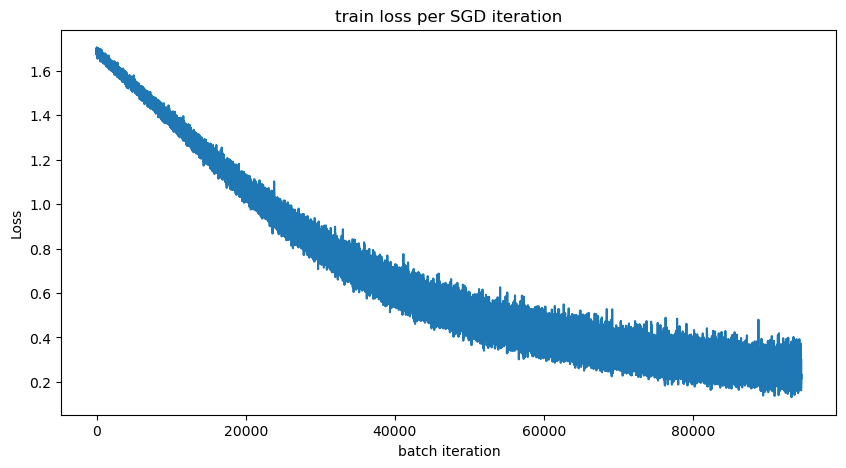

In [12]:

import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))  
plt.plot(training_losses_all)  

plt.title('train loss per SGD iteration')
plt.xlabel('batch iteration')
plt.ylabel('Loss')

plt.show()




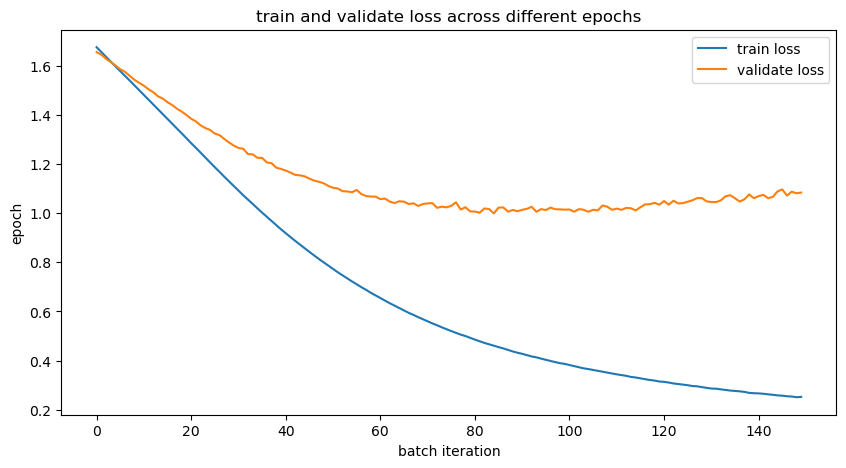

In [13]:
plt.figure(figsize=(10, 5))  
plt.plot(training_losses)  
plt.plot(validate_losses)
plt.title('train and validate loss across different epochs')
plt.xlabel('batch iteration')
plt.ylabel('epoch')
plt.legend(['train loss', 'validate loss'], loc='upper right')
plt.show()

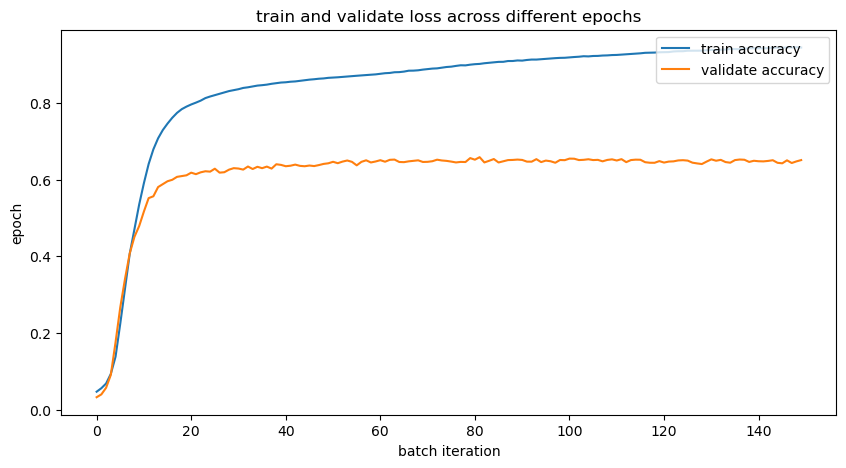

In [14]:
plt.figure(figsize=(10, 5))  
plt.plot(tr_acc)  
plt.plot(val_acc)

plt.title('train and validate loss across different epochs')
plt.xlabel('batch iteration')
plt.ylabel('epoch')
plt.legend(['train accuracy', 'validate accuracy'], loc='upper right')

plt.show()

## Test set metrics

In [15]:
pred = best_model(x_test)
pred = pred.detach().numpy()

pred = np.argmax(pred, axis=1)
# print accuracy
print("test accuracy: ", np.mean(pred == np.argmax(y_test.detach().numpy(), axis=1)))


test accuracy:  0.6589345563591462
